In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2021-01-06 18:40:45--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.4’

train_data.csv.4    100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-01-06 18:40:46 (78.2 MB/s) - ‘regression_dataset/train_data.csv.4’ saved [3776/3776]

--2021-01-06 18:40:46--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘r

In [ ]:
torch.manual_seed(0)

In [ ]:
train_df = pd.read_csv('regression_dataset/train_data.csv')

In [ ]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


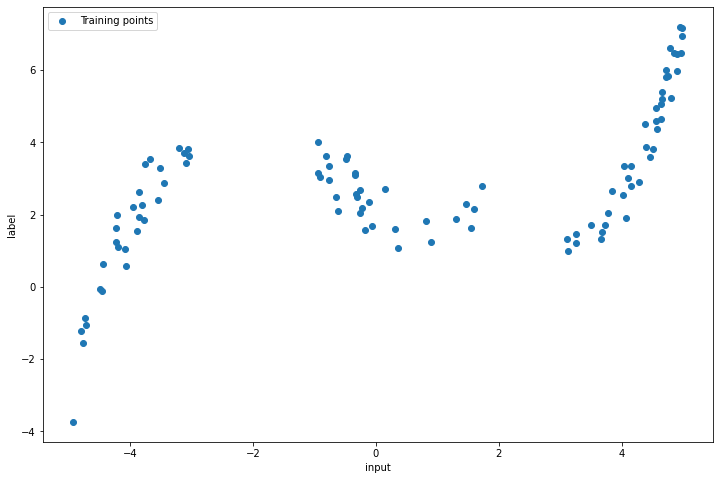

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

In [ ]:
import random

train_pd = pd.read_csv('regression_dataset/train_data.csv')
test_pd = pd.read_csv('regression_dataset/test_data.csv')

In [ ]:
train_data = train_pd.values
test_data = test_pd.values

random.seed(0)
random.shuffle(train_data)
random.shuffle(test_data)

In [ ]:
class RegNet(nn.Module):

  def __init__(self, Ni, Nh1, Nh2, No):
    super().__init__()
    self.fc1 = nn.Linear(Ni, Nh1, True)
    #torch.nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='tanh')
    self.fc2 = nn.Linear(Nh1, Nh2, True)
    #torch.nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='tanh')
    self.out = nn.Linear(Nh2, No)
    #torch.nn.init.kaiming_normal_(self.out.weight, nonlinearity='tanh')
    self.act = nn.Tanh()

  def forward(self, x):
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.out(x)
    return x

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
X_train = train_data[:, 0]
y_train = train_data[:, 1]
X_test = test_data[:, 0]
y_test = test_data[:, 1]

X_train = np.expand_dims(X_train, 1)
y_train = np.expand_dims(y_train, 1)
X_test = np.expand_dims(X_test, 1)
y_test = np.expand_dims(y_test, 1)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
!pip install skorch

The model Uses the momentum as optimizer. Adam works well but not as well with momentum. Adam coverges faster but since the dataset is not big, momentum can be a good choice. Dropout must be excluded since the results were pretty poor. Perhaps momentum with more epochs can converge to a better solution

In [ ]:
from skorch.callbacks import EarlyStopping

stopping_condition = EarlyStopping(
    monitor='valid_loss',
    patience=200,
    threshold=0.001,
    threshold_mode='rel',
    lower_is_better=True)

from skorch import NeuralNetRegressor
#Best params {'optimizer__lr': 0.001, 'module__drop2': 0.3, 'module__drop1': 0.2, 'module__Nh2': 256, 'module__Nh1': 128, 'max_epochs': 500}
net = NeuralNetRegressor(
    module=RegNet,
    module__Ni = 1,
    module__Nh1 = 512,
    module__Nh2 = 256,
    module__No = 1,
    max_epochs = 1000,
    device = device,
    optimizer = optim.SGD,
    optimizer__lr = 0.01,
    optimizer__momentum = 0.85,
    optimizer__weight_decay = 1e-04,
    criterion = nn.MSELoss,
    verbose = 1
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'optimizer__lr': [0.01, 0.001],
    'optimizer__momentum': [0.8, 0.85, 0.9],
    'max_epochs': [400, 700, 1000, 1500],
    'optimizer__weight_decay': [1e-03, 1e-04]
}

gs = RandomizedSearchCV(net, params, refit=True, scoring='neg_mean_squared_error', verbose=1, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        6.9672        5.3008  0.0048
      2        6.5097        4.4600  0.0070
      3        5.7656        3.6128  0.0049
      4        4.9346        2.9606  0.0047
      5        4.1641        2.5633  0.0055
      6        3.5170        2.3671  0.0050
      7        2.9900        2.2748  0.0049
      8        2.5585        2.2144  0.0061
      9        2.2169        2.1731  0.0045
     10        1.9926        2.1814  0.0059
     11        1.9221        2.2594  0.0060
     12        2.0072        2.3707  0.0050
     13        2.1872        2.4347  0.0042
     14        2.3607        2.3923  0.0060
     15        2.4431        2.2591  0.0041
     16        2.4117        2.1087  0.0041
     17        2.3010        2.0086  0.0059
     18        2.1612        1.9752  0.0052
     19        2.0237        1.9837  0.0042
     20        1.8968        2.0037  0.0059
     21        1.7809        2.0

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.9min finished


     29        1.6351        2.2951  0.0060
     30        1.6262        2.2460  0.0057
     31        1.6027        2.1875  0.0060
     32        1.5699        2.1308  0.0050
     33        1.5334        2.0829  0.0049
     34        1.4975        2.0456  0.0078
     35        1.4644        2.0166  0.0047
     36        1.4347        1.9927  0.0053
     37        1.4086        1.9716  0.0063
     38        1.3869        1.9533  0.0049
     39        1.3710        1.9390  0.0049
     40        1.3616        1.9290  0.0081
     41        1.3584        1.9217  0.0072
     42        1.3586        1.9140  0.0056
     43        1.3586        1.9032  0.0050
     44        1.3551        1.8887  0.0059
     45        1.3467        1.8722  0.0062
     46        1.3340        1.8568  0.0072
     47        1.3191        1.8447  0.0044
     48        1.3041        1.8365  0.0059
     49        1.2900        1.8313  0.0065
     50        1.2772        1.8278  0.0047
     51        1.2655        1.8

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.RegNet'>,
  module__Nh1=512,
  module__Nh2=256,
  module__Ni=1,
  module__No=1,
),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'max_epochs': [400, 700, 1000],
                                        'optimizer__lr': [0.001],
                                        'optimizer__momentum': [0.9],
                                        'optimizer__weight_decay': [0.001]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
net = gs.best_estimator_
print(gs.best_params_)


{'optimizer__weight_decay': 0.001, 'optimizer__momentum': 0.9, 'optimizer__lr': 0.001, 'max_epochs': 1000}


In [ ]:
net = NeuralNetRegressor(
    module=RegNet,
    module__Ni = 1,
    module__Nh1 = 512,
    module__Nh2 = 256,
    module__No = 1,
    max_epochs = gs.best_params_['max_epochs'],
    device = device,
    optimizer = optim.SGD,
    optimizer__lr = gs.best_params_['optimizer__lr'],
    optimizer__momentum = gs.best_params_['optimizer__momentum'],
    optimizer__weight_decay = gs.best_params_['optimizer__weight_decay'],
    criterion = nn.MSELoss,
    verbose = 1
)

In [ ]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        6.3577        2.3780  0.0058
      2        3.7621        2.2472  0.0068
      3        2.2346        3.2358  0.0059
      4        3.0429        2.1871  0.0072
      5        3.0798        2.2431  0.0052
      6        2.1508        2.1834  0.0050
      7        1.6935        3.0421  0.0051
      8        2.9454        2.4598  0.0065
      9        2.5763        2.4275  0.0054
     10        1.7392        2.0479  0.0053
     11        1.7242        2.5825  0.0048
     12        2.5145        1.7880  0.0052
     13        1.6601        2.1463  0.0055
     14        1.4499        1.8918  0.0058
     15        1.6150        2.2036  0.0059
     16        1.8848        1.7776  0.0054
     17        1.2469        1.6330  0.0056
     18        1.3038        1.4801  0.0064
     19        1.4477        1.9023  0.0053
     20        1.4788        1.3972  0.0054
     21        1.0570        1.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RegNet(
    (fc1): Linear(in_features=1, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (out): Linear(in_features=256, out_features=1, bias=True)
    (act): Tanh()
  ),
)

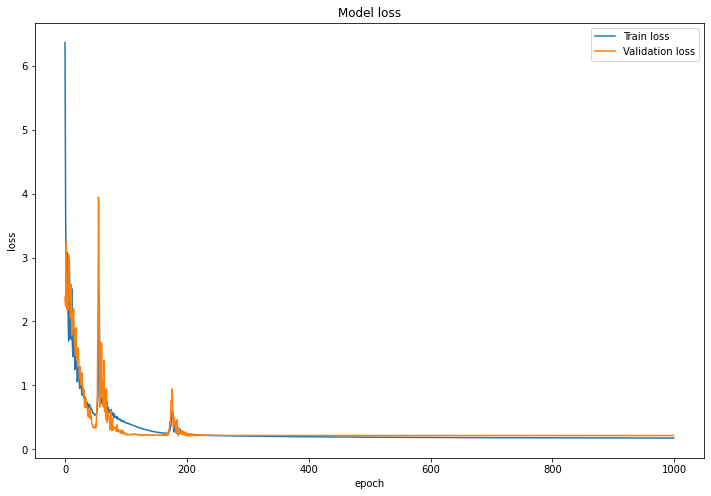

In [ ]:
# get train losses from all epochs, a list of floats
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

In [ ]:
loss_fn = nn.MSELoss()

y_pred = net.predict(X_train)
y_pred = torch.from_numpy(y_pred).float()

train_loss = loss_fn(y_pred, y_train)
print(f"TRAIN LOSS: {train_loss}")
y_pred = net.predict(X_test)
y_pred = torch.from_numpy(y_pred).float()

test_loss = loss_fn(y_pred, y_test)
print(f"TEST LOSS: {test_loss}")

TRAIN LOSS: 0.18626853823661804
TEST LOSS: 0.08310744911432266


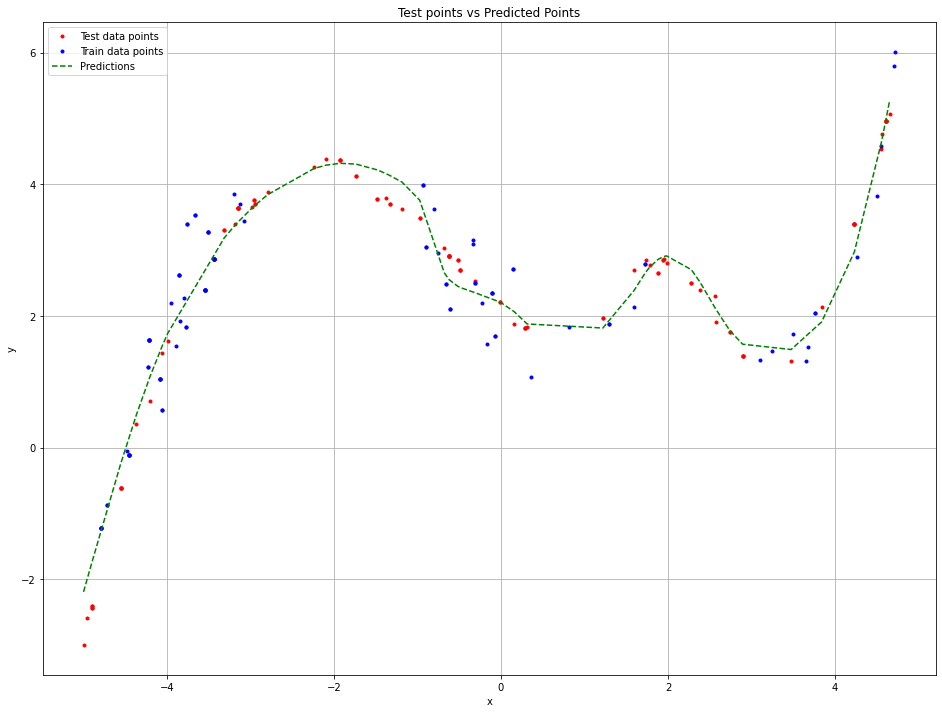

In [ ]:
#Plot Test points vs Prdicted points
zipped_lists = zip(X_test, y_pred)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X, y = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(16,12))
plt.plot(X_test, y_test, color='r', ls='', marker='.')
plt.plot(X_train, y_train, color='b', ls='', marker='.')
plt.plot(X, y, color='g', ls='--')
plt.title('Test points vs Predicted Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(['Test data points', 'Train data points', 'Predictions'], loc='upper left')
plt.show()

In [ ]:
net = net.module_
# First hidden layer
fc1_w = net.fc1.weight.data.cpu().numpy()
fc1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
fc2_w = net.fc2.weight.data.cpu().numpy()
fc2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

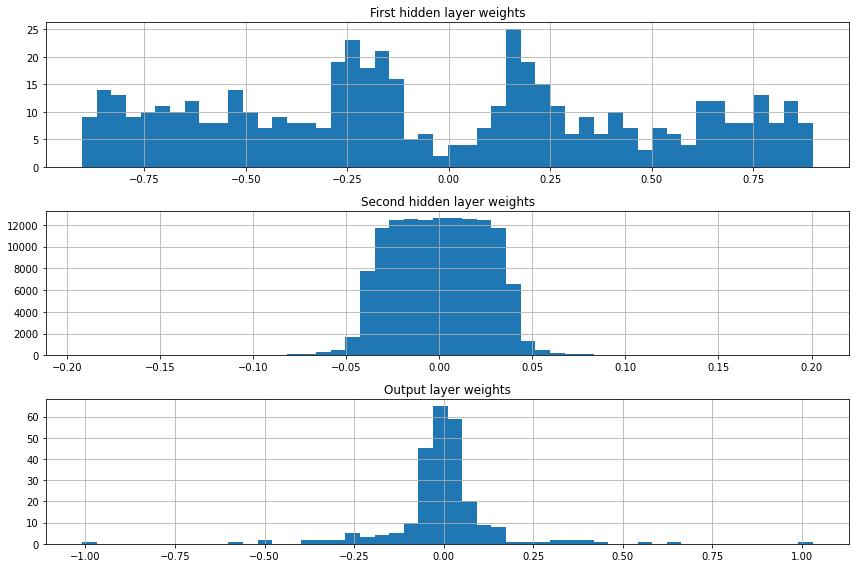

In [ ]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(fc1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(fc2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

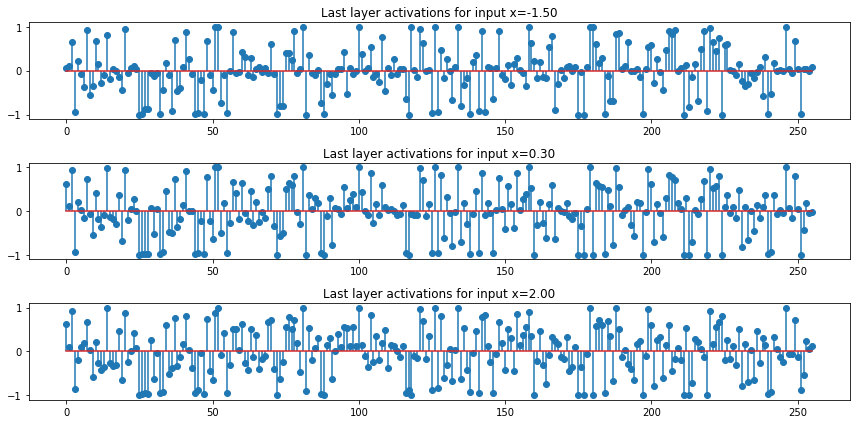

In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.tanh(output)
    
### Register hook
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-1.5]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.3]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()